# Introduction

This is a more realistic 2d dispersal model that includes diffusion and particle's response to the seabed/land

In [1]:
#Import packages
import netCDF4
from netCDF4 import Dataset,num2date 
from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4, AdvectionDiffusionM1, ErrorCode, ParcelsRandom, Variable, VectorField, DiffusionUniformKh, plotTrajectoriesFile
import numpy as np
import math
from datetime import datetime
from datetime import timedelta
from operator import attrgetter
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from copy import copy
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from IPython.display import Image

import itertools
import random

import cftime
import cartopy.crs as ccrs
import cartopy.feature as cfeatureinstall 

# Create a fieldset from HYCOM netcdf

## Check HYCOM data

In [2]:
#select which depth slice of the Northwest Pacific (nwp) you would like to work with
#directory = "HYCOM/nwp_surf.nc"
#directory = "HYCOM/nwp_900.nc"
directory = "HYCOM/nwp_1000.nc" 

nwp= xr.open_dataset(directory)

#decoding time gives you either a date or a value of hours since X
#nwp_surf= xr.open_dataset("HYCOM/nwp_surf.nc", decode_times=False)

nwp

<xarray.Dataset>
Dimensions:     (lat: 351, lon: 401, time: 366)
Coordinates:
    depth       float64 ...
  * lat         (lat) float64 10.0 10.08 10.16 10.24 ... 37.76 37.84 37.92 38.0
  * lon         (lon) float64 118.0 118.1 118.2 118.2 ... 149.8 149.9 150.0
  * time        (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2012-12-31
Data variables:
    water_u     (time, lat, lon) float32 ...
    water_v     (time, lat, lon) float32 ...
    water_temp  (time, lat, lon) float32 ...
Attributes:
    classification_level:      UNCLASSIFIED
    distribution_statement:    Approved for public release. Distribution unli...
    downgrade_date:            not applicable
    classification_authority:  not applicable
    institution:               Naval Oceanographic Office
    source:                    HYCOM archive file
    history:                   archv2ncdf3z
    field_type:                instantaneous
    Conventions:               CF-1.0 NAVO_netcdf_v1.0

## Designate the netcdf file(s) that will act as the fieldset

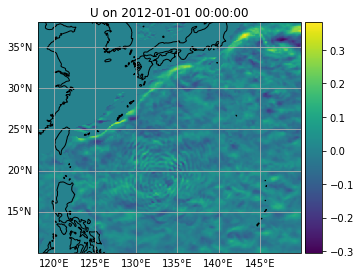

In [3]:
filenames = {'U': directory,
             'V': directory}

# Specify the varaibles and dimensions within those files 
# this information can be found in the description of the HYCOM above.

variables = {'U': 'water_u',
             'V': 'water_v'}
dimensions = {'lat': 'lat',
              'lon': 'lon',
              'time': 'time'}

#setting vmin designates HYCOM land cells (<-2000) as 0
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, vmin=-2000) 

fieldset.U.show()


## Mask the land/seabed

It may be necessary to introduce particle behaviours in response to encountering the seabed/land so these need to be mapped and masked. For this we work on the c-grid coordinates of U and V, not on the grid cell itsellf

In [4]:
#Import the HYCOM Northwest Pacific (nwp) slice as an xarray
nwp = xr.open_dataset(directory)

#Transform all the c-grid values of v or u velocities of 'nan' (seabed) into 1

landmask = np.logical_or(np.ma.masked_invalid(nwp['water_u'][0],0.).mask, # Creates a masked array
                         np.ma.masked_invalid(nwp['water_v'][0],0.).mask)

landmask = landmask.astype('int')
np.ma.masked_invalid(nwp['water_u'][0],0.) #where TRUE/1 = land and FALSE/0 = Ocean

masked_array(
  data=[[--, --, --, ..., -0.0010000000474974513, 0.007000000216066837,
         0.017000000923871994],
        [--, --, --, ..., -0.004000000189989805, 0.003000000026077032,
         0.012000000104308128],
        [--, --, --, ..., -0.007000000216066837, -0.003000000026077032,
         0.005000000353902578],
        ...,
        [--, --, --, ..., 0.017000000923871994, 0.027000000700354576,
         0.03400000184774399],
        [--, --, --, ..., 0.01100000087171793, 0.02200000174343586,
         0.03200000151991844],
        [--, --, --, ..., 0.03100000135600567, 0.03800000250339508,
         0.046000003814697266]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fil

In [5]:
landmask.shape

(351, 401)

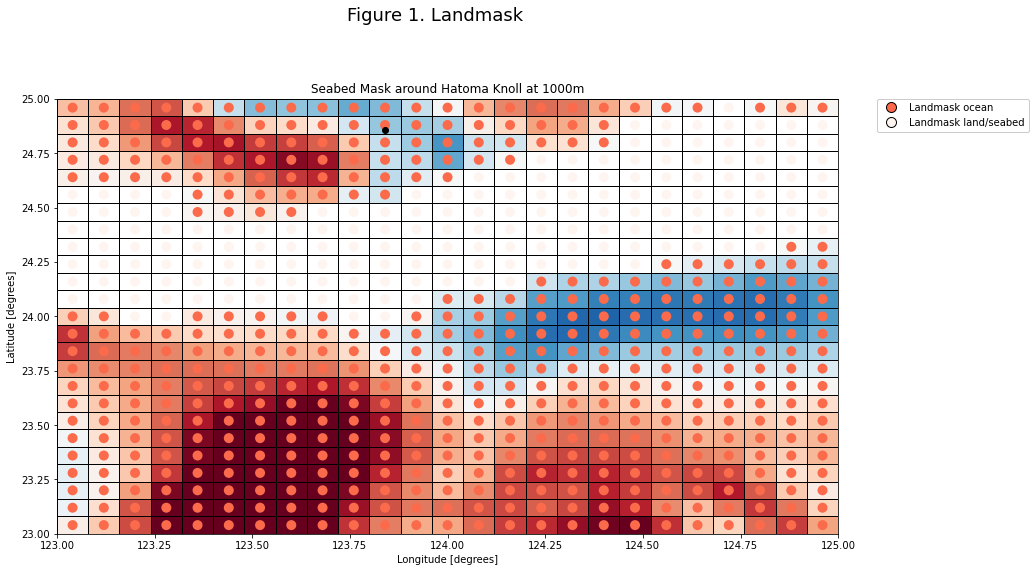

In [6]:
#Merge lat and long data arrays so that each location on the c-grid has a lat and long value on it
lons = fieldset.U.lon
lats = fieldset.U.lat

fieldmesh_x, fieldmesh_y = np.meshgrid(lons, lats)

#Import location of vent data
vent_sites=pd.read_csv('vent_location.csv', index_col = 'vent')

#set figure dimensions
fig = plt.figure(figsize=(14,8))
fig.suptitle('Figure 1. Landmask', fontsize=18, y=1.04)
ax=plt.axes()

#label and limit the axes to focus on small area arround Hatoma Knoll
ax.set_ylabel('Latitude [degrees]')
ax.set_xlabel('Longitude [degrees]')
ax.set_title('Seabed Mask around Hatoma Knoll at 1000m')
ax.set_xlim(123, 125)
ax.set_ylim(23, 25)

#colour the cells based on their V 
ax.pcolormesh(nwp['lon'], nwp['lat'], nwp['water_v'][0], cmap='RdBu', vmin=-0.1, vmax=0.1, edgecolors='k', linewidth=1)

#plot points at the c-grid coordinats and colour them based on the mask created above
#cmerge is how I transformed lat long into an array that is comparable to glamf and gphif
ax.scatter(fieldmesh_x, fieldmesh_y, c=landmask,  cmap='Reds_r', s=100, edgecolors='k', vmin=-1, linewidth=0.0001)
ax.scatter(vent_sites.at['SPOT, Hatoma Knoll','lon'], vent_sites.at['SPOT, Hatoma Knoll','lat'],c='black')


color_land = copy(plt.get_cmap('Reds'))(0)
color_ocean = copy(plt.get_cmap('Reds'))(128)

custom_lines = [Line2D([0], [0], c=color_ocean, marker='o', markersize=10, markeredgecolor='k', lw=0),
                Line2D([0], [0], c=color_land, marker='o', markersize=10, markeredgecolor='k', lw=0)]
ax.legend(custom_lines, ['Landmask ocean', 'Landmask land/seabed'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., framealpha=1)



plt.show()



Incorporate Kernal behaviour that has particles avoidng the seabed. To do this the sabed/land neds to be identified and then given a behaviour that moves particles back into the ocean (Boundary Condition) 

In [7]:
def Unbeaching_Field(landmask, fieldmesh_x, fieldmesh_y): # The function requires the input of a landmask and two mesh grids containing the horizontal and vertical information
    
    # Find indices of land and ocean
    oceancells = np.where(landmask == 0)
    landcells = np.where(landmask == 1)
        
    # Create empty arrays
    vectorfield_x = np.zeros(fieldmesh_x.shape)
    vectorfield_y = np.zeros(fieldmesh_y.shape)
        
    # Repeat the loop for all the land cells
    for i1 in range (len(landcells[1])):
        # Find the lon and lat for all of the land cells
        lon_coast = fieldmesh_x[landcells[0][i1], landcells[1][i1]]
        lat_coast = fieldmesh_y[landcells[0][i1], landcells[1][i1]]
            
        # Calculate the distance from each land cell to the ocean cells
        dist_lon = (lon_coast - fieldmesh_x[oceancells[0], oceancells[1]])
        dist_lat = (lat_coast - fieldmesh_y[oceancells[0], oceancells[1]])
        
        # Combine the values to get an array of the distances to ocean cells
        dist_to_ocean = np.sqrt(np.power(dist_lon, 2) + np.power(dist_lat, 2))
        # Calculate the minimum distance from each land cell to the ocean cells
        min_dist = np.min(dist_to_ocean)
        # Find the indices of the minimum distances within the overall distance array
        i_min_dist = np.where(dist_to_ocean == min_dist)
        
        # If there is only one ocean cell that is closest...
        if len(i_min_dist[0]) == 1:
            # Find the lon and lat of the ocean cell
            lon_ocean = fieldmesh_x[oceancells[0][i_min_dist], oceancells[1][i_min_dist]]
            lat_ocean = fieldmesh_y[oceancells[0][i_min_dist], oceancells[1][i_min_dist]]
            
            # Create a vector field 
            vectorfield_x[landcells[0][i1], landcells[1][i1]] = (lon_ocean - lon_coast) / np.sqrt((lon_ocean - lon_coast)**2 + (lat_ocean - lat_coast)**2)
            vectorfield_y[landcells[0][i1], landcells[1][i1]] = (lat_ocean - lat_coast) / np.sqrt((lon_ocean - lon_coast)**2 + (lat_ocean - lat_coast)**2)
        
        # If there are multiple ocean cells that are closest...
        elif len(i_min_dist[0]) > 1:
            # Take the mean of the lons and lats of all the cells
            lon_ocean = np.mean(fieldmesh_x[oceancells[0][i_min_dist], oceancells[1][i_min_dist]])
            lat_ocean = np.mean(fieldmesh_y[oceancells[0][i_min_dist], oceancells[1][i_min_dist]])
            
            # Create a vector field 
            vectorfield_x[landcells[0][i1], landcells[1][i1]] = (lon_ocean - lon_coast) / np.sqrt((lon_ocean - lon_coast)**2 + (lat_ocean - lat_coast)**2)
            vectorfield_y[landcells[0][i1], landcells[1][i1]] = (lat_ocean - lat_coast) / np.sqrt((lon_ocean - lon_coast)**2 + (lat_ocean - lat_coast)**2)    
    
    return vectorfield_x, vectorfield_y

In [8]:
# Apply the function (this may take a while)
landvector_U, landvector_V = Unbeaching_Field(landmask, fieldmesh_x, fieldmesh_y) 



/var/folders/gl/8vzxpv2903d5t3y25sg8b66m0000gp/T/ipykernel_15183/3574750108.py:45: RuntimeWarning: invalid value encountered in true_divide
  vectorfield_x[landcells[0][i1], landcells[1][i1]] = (lon_ocean - lon_coast) / np.sqrt((lon_ocean - lon_coast)**2 + (lat_ocean - lat_coast)**2)
/var/folders/gl/8vzxpv2903d5t3y25sg8b66m0000gp/T/ipykernel_15183/3574750108.py:46: RuntimeWarning: invalid value encountered in true_divide
  vectorfield_y[landcells[0][i1], landcells[1][i1]] = (lat_ocean - lat_coast) / np.sqrt((lon_ocean - lon_coast)**2 + (lat_ocean - lat_coast)**2)


In [9]:
# Convert unbeaching vectors to Field objects
U_land = Field('U_land', landvector_U, lon=lons, lat=lats, fieldtype='U', mesh='spherical')
V_land = Field('V_land', landvector_V, lon=lons, lat=lats, fieldtype='V', mesh='spherical')


In [10]:
#Write field object as netcdf
U_land.write("HYCOM/")
V_land.write("HYCOM/")

In [11]:
#Check the dimensions of saved field object
U_land1 = xr.open_dataset("HYCOM/U_land.nc")
U_land1

<xarray.Dataset>
Dimensions:       (y: 351, x: 401, time_counter: 1, depthu_land: 1)
Coordinates:
  * y             (y) float64 10.0 10.08 10.16 10.24 ... 37.76 37.84 37.92 38.0
  * x             (x) float64 118.0 118.1 118.2 118.2 ... 149.8 149.9 150.0
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
  * time_counter  (time_counter) float64 0.0
  * depthu_land   (depthu_land) float32 0.0
Data variables:
    U_land        (time_counter, depthu_land, y, x) float32 ...
Attributes:
    parcels_mesh:  spherical

In [12]:
#Import field objects from saved netcdf

fieldimensions = {'lon': 'x', 'lat': 'y'}
U_land1 = Field.from_netcdf("HYCOM/U_land.nc", 'U_land', fieldimensions, fieldtype='U')
V_land1 = Field.from_netcdf("HYCOM/V_land.nc", 'V_land', fieldimensions, fieldtype='V')


In [13]:


# Add land to ocean velocities that have been saved to the fieldset
#fieldset.add_field(U_land1)
#fieldset.add_field(V_land1)

#vectorfield_unbeaching = VectorField('UV_unbeach', U_land1, V_land1) # Combine and convert to vector field

# Add to fieldset the identification of land and ocean
#fieldset.add_field(Field('landmask', landmask, lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat, mesh='spherical')) 

#fieldset.add_vector_field(vectorfield_unbeaching) # Add to the fieldset

In [14]:


# Add land to ocean velocities that have been created above to the fieldset
fieldset.add_field(U_land)
fieldset.add_field(V_land)

vectorfield_unbeaching = VectorField('UV_unbeach', U_land, V_land) # Combine and convert to vector field

# Add to fieldset the identification of land and ocean
fieldset.add_field(Field('landmask', landmask, lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat, mesh='spherical')) 

fieldset.add_vector_field(vectorfield_unbeaching) # Add to the fieldset

## Define Diffusion

In [15]:
kh_zonal = 100
kh_meridional = 100

size2D = (fieldset.U.grid.ydim, fieldset.U.grid.xdim) # Store the dimensions of the zonal velocity from the FieldSet

fieldset.add_field(Field('Kh_zonal', kh_zonal*np.ones((size2D), dtype=np.float32), lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat, mesh='spherical'))
fieldset.add_field(Field('Kh_meridional', kh_meridional*np.ones((size2D), dtype=np.float32), lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat, mesh='spherical'))

fieldset.add_constant('dres', 0.01)

### Define kernal behaviours

In [16]:
#Define a custom kernal that decides whether to unbeach a particle or not based on unbeaching field
def Unbeaching(particle, fieldset, time):
    if particle.on_land == 1:  # If the particle is on land
        (u_land, v_land) = fieldset.UV_unbeach[time, particle.depth, particle.lat, particle.lon]  # the land U and V velocities are used
        particle.lon += u_land * particle.dt # particle lon becomes the u_land field at that timestep
        particle.lat += v_land * particle.dt # particle lat becomes the v_land field at that timestep
        particle.on_land = 0  # the particle is no longer on land

In [17]:
# #Define a custom kernal that records whether a particle is on seabed/land
def Sample_land(particle, fieldset, time):
    particle.on_land = fieldset.landmask[time, particle.depth, particle.lat, particle.lon]

In [18]:
#A kernel that  deletes a particle (solution to error messages)
def DeleteParticle(particle, fieldset, time):
    particle.delete()

## Create Particle set to release in fieldset

### Define custom particles


In [19]:
#Define the data that is recorded for each particle
class CustomParticle(JITParticle):
    #record whether the particle is on land to exhibit 'unbeaching' behaviour
    on_land = Variable('on_land', to_write=False) 

### Create Particle set

PROBLEM: When I specify a list of random times between dates for particles to release, the number of particles i can use is limited. 

SOLUTION: by changing the unit of measurement of the time from seconds to days

In [20]:

n = 1000 # Number of particle

#Defining a random start time is restricting the number of particles I can release for some unknown reason
def random_dates(start, end, n=n):

    start_u = start.value//10**9
    end_u = end.value//10**9

    return pd.to_datetime(np.random.randint(start_u, end_u, n), unit='s')


In [21]:
#Import location of vent data
vent_sites=pd.read_csv('vent_location.csv', index_col = 'vent')



#Use location of Hatoma Knoll as the point of dispersal

lat = list(np.repeat(vent_sites.at['SPOT, Hatoma Knoll','lat'],n))
lon = list(np.repeat(vent_sites.at['SPOT, Hatoma Knoll','lon'],n))


#Create a list of random dates and time using the above function
start = pd.to_datetime('2012-01-01')
end = pd.to_datetime('2012-02-01')
random_start=random_dates(start, end)

#Round up to days
random_start = random_start.round('D')

random_start = np.expand_dims(random_start,axis=1)




In [22]:

pset = ParticleSet(fieldset=fieldset, # The fieldset created at the start
                   pclass=CustomParticle, # The CustomParticle CustomParticle defined above
                   lon=lon, # longitude data
                   lat=lat, # latitude data
                   time=random_start) # Don't need to randomize time because diffusion will spread the particles



### Implement kernel behaviours defined above

In [23]:
# Cutom kernels need to be cast into a kernel object using pset.Kernel before they can function 
kernels = pset.Kernel(AdvectionRK4)+ pset.Kernel(Sample_land)+ pset.Kernel(Unbeaching) +pset.Kernel(DiffusionUniformKh)



## Execute PARCELS!

In [24]:
# input the time manually (as hours since 2000-01-01 00:00:00 )
output_file = pset.ParticleFile(name="Oki_advdif_particles.nc", outputdt= timedelta(days=1)) # the file name and the time step of the outputs [I had issues with the 'timedelta' so i just changed it to a positive double (1)]
pset.execute(kernels,                 # the kernel (which defines how particles move)
             runtime= timedelta(days=200),    # the total length of the run
             dt= timedelta(hours=1),          # the timestep of the kernel
             recovery ={ErrorCode.ErrorOutOfBounds: DeleteParticle, 
                        ErrorCode.ErrorInterpolation: DeleteParticle},# How to handle error messages
             output_file=output_file)

INFO: Compiled ArrayCustomParticleAdvectionRK4Sample_landUnbeachingDiffusionUniformKh ==> /var/folders/gl/8vzxpv2903d5t3y25sg8b66m0000gp/T/parcels-502/lib86996d494a07b88b56a07c0b452e53f2_0.so
INFO: Temporary output files are stored in out-FMYUDMTB.
INFO: You can use "parcels_convert_npydir_to_netcdf out-FMYUDMTB" to convert these to a NetCDF file during the run.
100% (17280000.0 of 17280000.0) |########| Elapsed Time: 0:00:07 Time:  0:00:07


/Users/rentalforgsst37527/opt/anaconda3/envs/py3_parcels/lib/python3.10/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


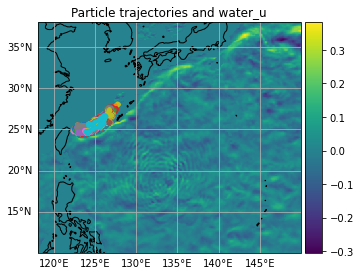

In [25]:
output_file.export()
plotTrajectoriesFile('Oki_advdif_particles.nc',
                     tracerfile='HYCOM/nwp_1000_2012-01-01.nc',
                     tracerlon='lon',
                     tracerlat='lat',
                     tracerfield='water_u');

## Analyse Trajectory Output 


The output I require is the number of particles that reach each vent site. To do this I need to identify the terminal location of each particle (probability density) and then extract this density for each grid cell that contains a vent site


In [26]:
#Import the trajectory output as an Xarray

import xarray as xr

x_output = xr.open_dataset('Oki_advdif_particles.nc')
x_output

<xarray.Dataset>
Dimensions:     (traj: 1000, obs: 201)
Dimensions without coordinates: traj, obs
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float32 ...
    lon         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.0
    parcels_mesh:           spherical

In [27]:
x_output['time']

<xarray.DataArray 'time' (traj: 1000, obs: 201)>
[201000 values with dtype=datetime64[ns]]
Dimensions without coordinates: traj, obs
Attributes:
    long_name:      
    standard_name:  time
    axis:           T

/var/folders/gl/8vzxpv2903d5t3y25sg8b66m0000gp/T/ipykernel_15183/2651959544.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r*" (-> color='r'). The keyword argument will take precedence.
  ax.plot(x_output['lon'][:,90], x_output['lat'][:,90],
/var/folders/gl/8vzxpv2903d5t3y25sg8b66m0000gp/T/ipykernel_15183/2651959544.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r^" (-> color='r'). The keyword argument will take precedence.
  ax.plot(vent_sites.at['SPOT, Hatoma Knoll','lon'], vent_sites.at['SPOT, Hatoma Knoll','lat'],


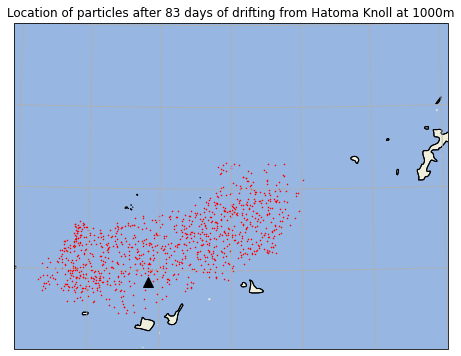

In [28]:
import cartopy.feature as cfeature


# Create a spatial map of your selected location with cartopy
#25.671710817443696, 125.73526892535367 24.228078631571, 123.22629785335853
extent = [122, 128, 24, 28]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

f, ax = plt.subplots(figsize=(12, 6),
                     subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)})
ax.coastlines()
# Plot the selected location 
ax.plot(x_output['lon'][:,90], x_output['lat'][:,90], 
        'r*', 
        transform=ccrs.PlateCarree(),
       color="red", markersize=1)

ax.plot(vent_sites.at['SPOT, Hatoma Knoll','lon'], vent_sites.at['SPOT, Hatoma Knoll','lat'], 
        'r^', 
        transform=ccrs.PlateCarree(),
       color="black", markersize=10)

ax.set_extent(extent)
ax.set(title="Location of particles after 83 days of drifting from Hatoma Knoll at 1000m")

# Adds continent boundaries to the map
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)

ax.gridlines()
plt.show()